In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-04-14 13:55:18.638628: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 13:55:18.676567: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Ready"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def ShowPrediction(filename: str, model):
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)
    test_df, predictions = MakeSinglePrediction(file_path, model, labels, NORM_PARAM)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        plt.plot(denormed_time, denormed_label)
        plt.plot(denormed_time, denormed_pred)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

## Importing Model

In [4]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history = LoadModel(model_dir)

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("model_history keys: {}".format(model_history.keys()))

Found 8 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index 	Model-name
  [0]. 	ANN 2022-04-06 06:35:28
  [1]. 	ANN 2022-04-14 13:42:13
  [2]. 	ANN 2022-04-13 11:00:28
  [3]. 	ANN 2022-04-14 12:43:56
  [4]. 	ANN 2022-04-06 06:23:17
  [5]. 	ANN 2022-04-13 11:49:24
  [6]. 	ANN 2022-04-13 13:40:18
  [7]. 	ANN 2022-04-13 11:16:18
You selected model ANN 2022-04-14 12:43:56

model loaded
model history loaded
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


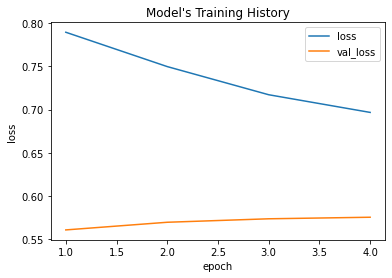

In [5]:
metric = 'loss'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend(['loss', 'val_{}'.format(metric)])
plt.show()

## Making Few Predictions

## R2 Results

In [6]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,elv_l_rad
count,61.000000
mean,-2.671076
std,14.481540
min,-111.631580
25%,-1.000367
50%,-0.024150
75%,0.533484
max,0.901287


In [7]:
r2_df.nlargest(8, columns=labels)

,filename,elv_l_rad
1,flight_17891.csv,0.901287
38,flight_34487.csv,0.775897
54,flight_17821.csv,0.758033
23,flight_13990.csv,0.748691
43,flight_36933.csv,0.711429
58,flight_20048.csv,0.692027
44,flight_36526.csv,0.678079
12,flight_17411.csv,0.665302


In [18]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(50, columns=labels)

,filename,elv_l_rad
41,flight_21884.csv,-111.631580
30,flight_23314.csv,-18.203416
39,flight_10603.csv,-9.634326
34,flight_38097.csv,-7.531707
18,flight_23324.csv,-5.393799
27,flight_39372.csv,-2.682128
28,flight_35322.csv,-2.478783
2,flight_27177.csv,-1.977318
9,flight_21054.csv,-1.904496
32,flight_38852.csv,-1.615718


filename: flight_19237.csv
timespan: 308.0
mae: 0.7375654578208923


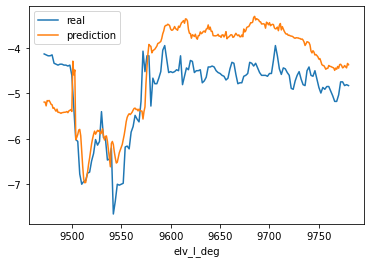

In [19]:
filename_to_predict = "flight_19237.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model)

min: 212.0
max: 498.0
avg: 324.42622950819674


(array([4., 2., 2., 2., 2., 1., 4., 0., 2., 6., 2., 3., 3., 3., 5., 0., 6.,
        2., 4., 2., 2., 1., 1., 0., 1., 0., 0., 0., 0., 1.]),
 array([212.        , 221.53333333, 231.06666667, 240.6       ,
        250.13333333, 259.66666667, 269.2       , 278.73333333,
        288.26666667, 297.8       , 307.33333333, 316.86666667,
        326.4       , 335.93333333, 345.46666667, 355.        ,
        364.53333333, 374.06666667, 383.6       , 393.13333333,
        402.66666667, 412.2       , 421.73333333, 431.26666667,
        440.8       , 450.33333333, 459.86666667, 469.4       ,
        478.93333333, 488.46666667, 498.        ]),
 <BarContainer object of 30 artists>)

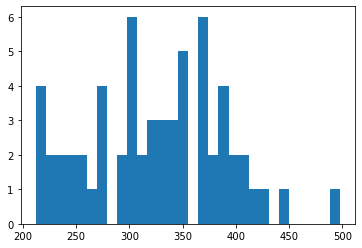

In [10]:
timespans = []
test_dir = ph.GetProcessedPath("Test")
dir_list = os.listdir(test_dir)
for filename in dir_list:
    filepath = os.path.join(test_dir, filename)
    _df = pd.read_csv(filepath)

    timespans.append(_df.loc[_df.shape[0]-1,"time_s"] - _df.loc[0,"time_s"])

print("min: {}".format(min(timespans)))
print("max: {}".format(max(timespans)))
print("avg: {}".format(np.mean(timespans)))

plt.hist(timespans, 30)

In [11]:
bellow_200 = []
for timespan in timespans:
    if timespan < 200:
        bellow_200.append(timespan)

len(bellow_200)

0